# Sentiment Scores: Chunks

For system details and resources, see PhD_SystemCheck.ipynb and PhD_Modules.ipynb

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from langchain.text_splitter import RecursiveCharacterTextSplitter

tokenizer = RegexpTokenizer('\w+')
sentenceTokenizer = nltk.data.load('tokenizers/punkt/english.pickle') #Load tokenizer
sentimentAnalyzer = SentimentIntensityAnalyzer() #Initialize sentiment scorer

text_splitter = RecursiveCharacterTextSplitter( #Initialize text splitter for chunking process
    chunk_size=1374,
    chunk_overlap=475,
    length_function=len,
    is_separator_regex=False,
)

len(sentimentAnalyzer.lexicon)

7268

In [2]:
#Corpus = PlaintextCorpusReader('test/cleaned', '.*txt') #Define corpus
#len(Corpus.fileids()) #How many files

Corpus = PlaintextCorpusReader('20240628_PhD_Diaries/cleaned', '.*txt') #Define corpus
len(Corpus.fileids()) #How many files

4

In [3]:
sentiment = pd.DataFrame(columns = ['text',
                                    'docid',
                                    'sequence', 
                                    'totalTokens', 
                                    'uniqueTokens', 
                                    'lexicalDiversity', 
                                    'scoreNeg', 
                                    'scoreNeu', 
                                    'scorePos', 
                                    'scoreCom']) # Create a new dataframe to hold sentences, letter id and compound scores

for fileid in Corpus.fileids(): # For each file in the corpus
    print(fileid) # Show progress
    text = Corpus.raw(fileid) # Place the string into the object "text"
    chunks = text_splitter.split_text(text)
    sequence = 0 # Create a counter to keep track of sentence order
    for chunk in chunks: # For each chunk in this list  
        sequence +=1 # Counter updater    
        #print(sequence) # Show progress
        # Do basic metrics
        tokens = tokenizer.tokenize(chunk)
        totalTokens = len(tokens)
        uniqueTokens = len(set(tokens))
        lexicalDiversity = uniqueTokens/totalTokens
        # Score sentiment
        sentences = sentenceTokenizer.tokenize(chunk) # Place sentences into a list called "sentences"
        scoreNeg = 0.0
        scoreNeu = 0.0
        scorePos = 0.0
        scoreCom = 0.0
        #sequence = 0 # Create a counter to keep track of sentence order
        for sentence in sentences: # For each sentence in the letter 
            #sequence +=1 # Counter updater
            scores = sentimentAnalyzer.polarity_scores(sentence) # Calculate sentiment scores
            scoreNeg += scores["neg"]
            scoreNeu += scores["neu"]
            scorePos += scores["pos"]
            scoreCom += scores["compound"]
        scoreNeg = scoreNeg / len(sentences)
        scoreNeu = scoreNeu / len(sentences)
        scorePos = scorePos / len(sentences)
        scoreCom = scoreCom / len(sentences)
        new_row = pd.Series([chunk, fileid, sequence, totalTokens, uniqueTokens, lexicalDiversity, scoreNeg, scoreNeu, scorePos, scoreCom], index=['text','docid', 'sequence', 'totalTokens', 'uniqueTokens', 'lexicalDiversity', 'scoreNeg', 'scoreNeu', 'scorePos', 'scoreCom'])
        sentiment = pd.concat([sentiment, new_row.to_frame().T], ignore_index=True)
print("done")

D0002.txt
D0003.txt
D0007.txt
D0009.txt
done


In [4]:
# What is the overall shape of the dataframe
sentiment.shape

(1023, 10)

In [5]:
#re-jig data types
cols = ['lexicalDiversity', 'scoreNeg', 'scoreNeu', 'scorePos', 'scoreCom']
sentiment[cols] = sentiment[cols].apply(pd.to_numeric, errors='coerce', axis=1)

sentiment['totalTokens'] = sentiment['totalTokens'].astype(int)
sentiment['uniqueTokens'] = sentiment['uniqueTokens'].astype(int)
sentiment['sequence'] = sentiment['sequence'].astype(int)

sentiment.dtypes

text                 object
docid                object
sequence              int64
totalTokens           int64
uniqueTokens          int64
lexicalDiversity    float64
scoreNeg            float64
scoreNeu            float64
scorePos            float64
scoreCom            float64
dtype: object

In [6]:
sentiment.describe()

,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,165.379277,274.441838,168.459433,0.615519,0.050303,0.897547,0.051768,-0.071383
std,119.911753,15.672601,9.952139,0.045344,0.033944,0.042938,0.029832,0.361995
min,1.000000,97.000000,75.000000,0.464164,0.000000,0.706769,0.002333,-0.991600
25%,64.500000,264.000000,163.000000,0.585584,0.025367,0.872396,0.029606,-0.158705
50%,137.000000,276.000000,168.000000,0.616197,0.043667,0.903000,0.048000,-0.011550
75%,257.500000,284.000000,174.000000,0.647834,0.069000,0.926697,0.067371,0.089422
max,447.000000,309.000000,199.000000,0.773196,0.227000,0.981800,0.218500,0.988600


<Axes: >

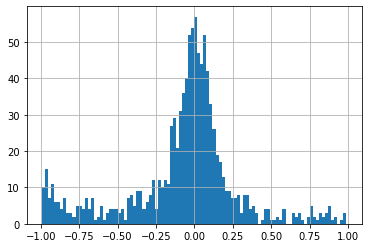

In [7]:
sentiment['scoreCom'].hist(bins=100)

In [8]:
sentiment.loc[sentiment['scoreCom'] > .75]

,text,docid,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom
20,down at a gallp but whether it on anything Tom...,D0002.txt,21,275,165,0.600000,0.0460,0.8610,0.0930,0.87150
30,so glad had been very busy at Elleston found t...,D0002.txt,31,286,167,0.583916,0.0270,0.9000,0.0730,0.84130
42,when I heard it Mr Besly is very nice he will ...,D0002.txt,43,286,167,0.583916,0.0230,0.9000,0.0770,0.92510
43,nothing the others he said had been up half th...,D0002.txt,44,281,166,0.590747,0.0165,0.8970,0.0865,0.83335
52,towards warner Mr agers residence we got lost ...,D0002.txt,53,275,159,0.578182,0.0430,0.8720,0.0850,0.89910
54,ca to Marry ale and stayed the night every thi...,D0002.txt,55,285,169,0.592982,0.0000,0.9200,0.0800,0.76655
56,Wednesday Sec 26th very hot up early but could...,D0002.txt,57,290,172,0.593103,0.0000,0.9145,0.0855,0.85815
65,where we are staying and went to bed gave him ...,D0002.txt,66,287,159,0.554007,0.0230,0.8670,0.1100,0.97580
76,water lank and trough getting on got a all thi...,D0002.txt,77,284,175,0.616197,0.0000,0.8640,0.1360,0.98860
77,more like my own home then any thing I have se...,D0002.txt,78,286,178,0.622378,0.0840,0.7930,0.1240,0.88070


In [9]:
sentiment.iloc[33,0] 

'keen goss preached here in the Afternoon but in coming from a far house he lost his way so we were waiting a long the for him everall famileys were here after taking tea he left for Cotton for evening sewick We went for a walk in the cool but the night was very close was glad to put out the lamp in the bedroom the blow fles were so troublesome Monday Sec 3rd Another close day we are going to Warnal Station to see along her hang on is take myself we left Calca at meed miss Hosken driving what quiet horses here then stood waiting nearly an hour with the fly tormenting them fearfully I fancy ours fasting like it and the driving of this young Lady was something grand reing hanging loose one horse galloping while the other trotted several times she nearly run against a the trees ten miles drive brought us to Mr agers farm where his mother in Law Mrs Winnison is a presant living they were all glad to me and I to see them the Thomps drove up to Mr agers I had to stay with Mrs Smison had dinn

In [10]:
sumVal = sentiment['scoreNeg'] + sentiment['scoreNeu'] + sentiment['scorePos']
sumVal.describe()

count    1023.000000
mean        0.999617
std         0.004976
min         0.923000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.001000
dtype: float64

<Axes: >

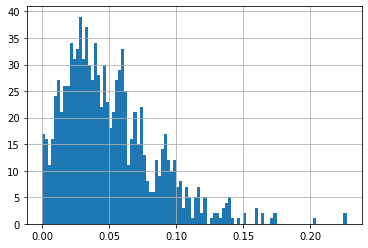

In [11]:
sentiment['scoreNeg'].hist(bins=100)

<Axes: >

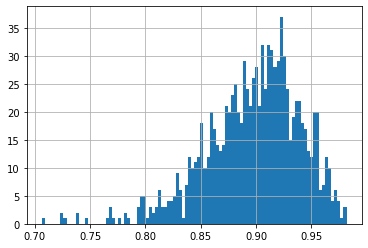

In [12]:
sentiment['scoreNeu'].hist(bins=100)

<Axes: >

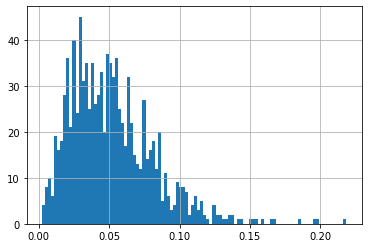

In [13]:
sentiment['scorePos'].hist(bins=100)

<Axes: >

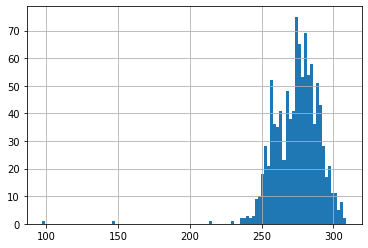

In [14]:
sentiment['totalTokens'].hist(bins=100)

<Axes: >

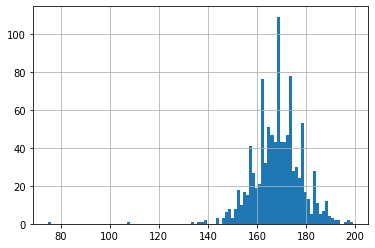

In [15]:
sentiment['uniqueTokens'].hist(bins=100)

<Axes: >

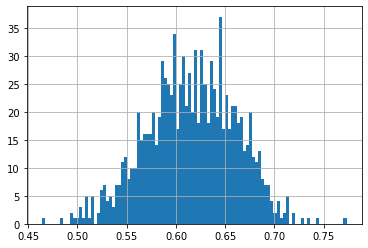

In [16]:
sentiment['lexicalDiversity'].hist(bins=100)

In [17]:
# Remove the .txt from the file name
sentiment['docid'] = sentiment['docid'].str.replace(r'.txt', '', regex=True)
sentiment.head()

,text,docid,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom
0,Charra Wednesday Nov 4th 1883 A nice cool day ...,D0002,1,277,171,0.617329,0.070000,0.891000,0.039000,-0.379767
1,night so that I can't get up in the morning ha...,D0002,2,281,170,0.604982,0.044333,0.907667,0.048000,-0.058833
2,Frank did not arrive till 2P.M so after he had...,D0002,3,276,170,0.615942,0.074750,0.884500,0.041000,-0.137725
3,to Camp caused it. Mrs Roberts lent me two pai...,D0002,4,270,163,0.603704,0.045600,0.925600,0.028600,-0.216920
4,which I can't understand but hope to know toni...,D0002,5,282,147,0.521277,0.089857,0.892286,0.017857,-0.371971


In [18]:
# Add a column "chunks" showing total number of chunks extracted from each letter
sentiment['chunks'] = sentiment.groupby('docid')['sequence'].transform('max')
sentiment.head()

,text,docid,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom,chunks
0,Charra Wednesday Nov 4th 1883 A nice cool day ...,D0002,1,277,171,0.617329,0.070000,0.891000,0.039000,-0.379767,447
1,night so that I can't get up in the morning ha...,D0002,2,281,170,0.604982,0.044333,0.907667,0.048000,-0.058833,447
2,Frank did not arrive till 2P.M so after he had...,D0002,3,276,170,0.615942,0.074750,0.884500,0.041000,-0.137725,447
3,to Camp caused it. Mrs Roberts lent me two pai...,D0002,4,270,163,0.603704,0.045600,0.925600,0.028600,-0.216920,447
4,which I can't understand but hope to know toni...,D0002,5,282,147,0.521277,0.089857,0.892286,0.017857,-0.371971,447


In [19]:
# Add a column "Position" showing the location of the chunk relative to the whole 
# That is, how far through the letter does the chunk appear?
sentiment['position'] = sentiment['sequence'] / sentiment['chunks']
sentiment.head()

,text,docid,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom,chunks,position
0,Charra Wednesday Nov 4th 1883 A nice cool day ...,D0002,1,277,171,0.617329,0.070000,0.891000,0.039000,-0.379767,447,0.002237
1,night so that I can't get up in the morning ha...,D0002,2,281,170,0.604982,0.044333,0.907667,0.048000,-0.058833,447,0.004474
2,Frank did not arrive till 2P.M so after he had...,D0002,3,276,170,0.615942,0.074750,0.884500,0.041000,-0.137725,447,0.006711
3,to Camp caused it. Mrs Roberts lent me two pai...,D0002,4,270,163,0.603704,0.045600,0.925600,0.028600,-0.216920,447,0.008949
4,which I can't understand but hope to know toni...,D0002,5,282,147,0.521277,0.089857,0.892286,0.017857,-0.371971,447,0.011186


## Summary Stats

In [20]:
sentiment.dtypes

text                 object
docid                object
sequence              int64
totalTokens           int64
uniqueTokens          int64
lexicalDiversity    float64
scoreNeg            float64
scoreNeu            float64
scorePos            float64
scoreCom            float64
chunks                int64
position            float64
dtype: object

In [21]:
#sentiment[['sequence', 'scoreNeg', 'scorePos', 'scoreCompound', 'totalTokens', 'uniqueTokens', 'lexicalDiversity', 'position']] = sentiment[['sequence', 'scoreNeg', 'scorePos', 'scoreCompound', 'totalTokens', 'uniqueTokens', 'lexicalDiversity', 'position']].astype(str).astype(float)

In [22]:
sentiment.describe()

,sequence,totalTokens,uniqueTokens,lexicalDiversity,scoreNeg,scoreNeu,scorePos,scoreCom,chunks,position
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,165.379277,274.441838,168.459433,0.615519,0.050303,0.897547,0.051768,-0.071383,329.758553,0.501955
std,119.911753,15.672601,9.952139,0.045344,0.033944,0.042938,0.029832,0.361995,126.194137,0.288816
min,1.000000,97.000000,75.000000,0.464164,0.000000,0.706769,0.002333,-0.991600,102.000000,0.002237
25%,64.500000,264.000000,163.000000,0.585584,0.025367,0.872396,0.029606,-0.158705,323.000000,0.252226
50%,137.000000,276.000000,168.000000,0.616197,0.043667,0.903000,0.048000,-0.011550,323.000000,0.501548
75%,257.500000,284.000000,174.000000,0.647834,0.069000,0.926697,0.067371,0.089422,447.000000,0.752000
max,447.000000,309.000000,199.000000,0.773196,0.227000,0.981800,0.218500,0.988600,447.000000,1.000000


<Axes: >

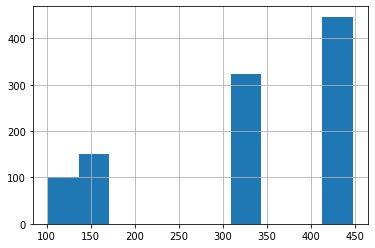

In [23]:
sentiment['chunks'].hist()

In [24]:
sentiment.to_csv('20240701_PhD_SentimentDiary-Chunks.csv', index = True, encoding="utf-8")